TL&DR: This is a notebook that illustrates what is wrong with 
* turning 2D spatial offsets ($\Delta x, \Delta y$) into a 1D Euclidean distance then histogram the Euclidean distance values into a probability density function (PDF)


This matters when we try to draw conclusions about statistical significance from the resulting binned PDF.

We explain both in terms of the math and then numerically show what is wrong.


Lessons learned:

1) do not bin the data before taking significance level or computing the summary statistic

2) be careful how you transform your data if you get your scientifc conclusion from the transformed data.

## the visual way of explaining why there is a singularity at offset = 0

for radial histogram bins, the area of each bin is $A = \pi (r_2^2 - r_1^2)$ 
which grows bigger as $r_2, r_1$ increases.

So at the bin size $r_2 \rightarrow 0$ and $r_1 = 0$, the area of the bin is also very small. Naturally it contains almost NO data point.


for cartesian histogram bins, each bin has the SAME size.

## the mathematical way of stating things:

We compute the population offsets between the two sets of data 
i.e. $(\Delta x, \Delta y)$ which exhibits rotational symmetry.
I will abbreviate $\Delta x \equiv x$  and $\Delta y \equiv y$ from this point on: 

As an astrophysicist, I would like use the simplest representation of my offset, by transform my offset variables from:   
1) $(x, y) \rightarrow s$, by computing the Euclidean distance.

Note that the support of the variables has gone from:
$\mathbb{R}^2 \rightarrow \mathbb{R}$.
which is NOT a one-to-one mapping.

An alternative mapping is:   
2) $(x, y) \rightarrow (s, \theta)$ 
those support goes from $\mathbb{R}^2 \rightarrow [0, \infty), [-\pi, \pi]$

As we know, the Jacobian that goes from 2D cartesian coordinates to polar coordinates is:

$f(x, y) dx dy = f(s \cos \theta, s \sin \theta) s~ds d\theta$ -- (1)

The Jacobian term, $s$ on the RHS of eq. (1) reflects the singularity at zero. 



## an alternative way of transforming the variables

For mapping that is not one-to-one (bijective)
we look at the cumulative distribution function $F$ instead:

$F(|S| \leq s) = F(-s \leq S \leq s )$

And we can also use the following identity to compute the PDF numerically: 

$\frac{d}{ds} \int^{\phi(s)}_{\varphi(s)} F(s) ds = F(\phi(s))\cdot \phi(s) - F(\varphi(s)) \cdot \varphi(s)$ 

but of course we can avoid all these conversions just by sticking to the 2D representation.

# For the skeptic, here are some numerical consequences:

In [1]:
%matplotlib inline 
%autoreload 2 

In [2]:
from astropy.stats import (biweight_location, 
                           biweight_midvariance)

/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy

# draw values from a standard bivariate normal distribution

In [4]:
rand_vars = multivariate_normal.rvs(np.zeros(2), np.ones(2), 
                                    size=5000)

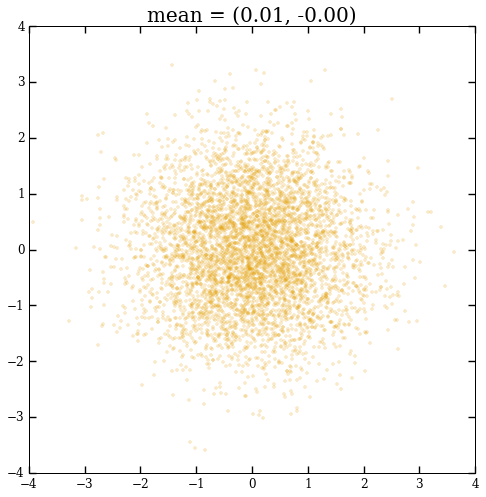

In [40]:
plt.figure(figsize=(8, 8))
plt.axes(aspect='equal')


means = [np.mean(rand_vars.transpose()[i]) 
         for i in range(rand_vars.shape[1])]
plt.title("mean = ({0:.2f}, {1:.2f})".format(*means))

Is our significance level hypothesis test affected by representation?

It should not be if we count how many data points are within the confidence level.

In [7]:
import sys 
sys.path.append("../")

import homebrewed modules

In [9]:
import get_KDE as getKDE

In [42]:
from plot_gal_prop import plot_cf_contour
import plot_cred_int as plotCI

In [57]:
fhat = getKDE.do_KDE(rand_vars, w=None, convert_to_py_format=True)

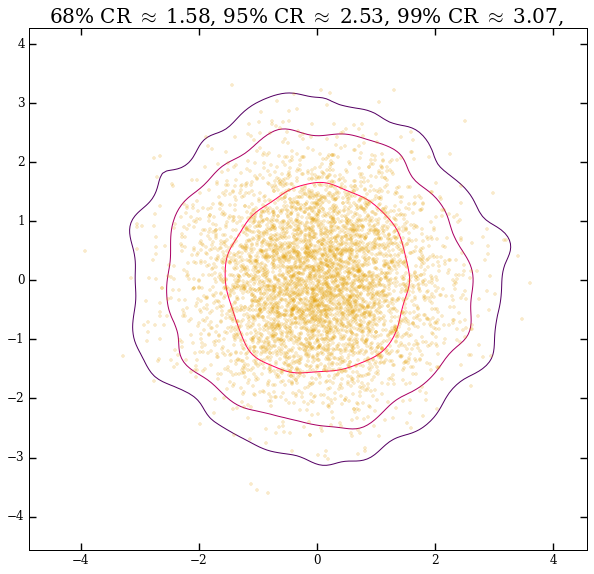

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
lvls = plot_cf_contour(fhat['estimate'], 
                fhat['eval_points'][0],
                fhat['eval_points'][1], ax=ax, lvls=[68, 95, 99])
ax.plot(rand_vars.transpose()[0], 
        rand_vars.transpose()[1], '.', alpha=0.2)

cf68 = lvls[0.68]
cf68_avg = np.mean([np.sqrt(np.dot(est, est)) for est in cf68])

cf95 = lvls[0.95]
cf95_avg = np.mean([np.sqrt(np.dot(est, est)) for est in cf95])

cf99 = lvls[0.99]
cf99_avg = np.mean([np.sqrt(np.dot(est, est)) for est in cf99])

ax.set_title(r'68% CR $\approx$ {0:.2f}, '.format(cf68_avg) +
             r'95% CR $\approx$ {0:.2f}, '.format(cf95_avg) + 
             r'99% CR $\approx$ {0:.2f}, '.format(cf99_avg)
            )


# compute the Euclidean distances of the points

In [59]:
abs_rand_vars = [np.sqrt(np.dot(var, var)) for var in rand_vars]

use the `astropy.stats` functions to compute some common robust statistic:

In [60]:
biweight_location(abs_rand_vars)

1.2193161144195737

In [61]:
biweight_midvariance(abs_rand_vars)

0.65297424181985442

In [62]:
np.mean(abs_rand_vars)

1.2687761581876926

So I get a mean offset that is not even close to being zero. This is counterintuitive as I drew my data from a standard normal bivariate Gaussian!

Compute the confidence interval again!

{'low68': 0.59770813539226486, 'up99': 3.1690396373752483, 'loc': 1.2193161144195737, 'up95': 2.7163915262165332, 'up68': 1.9411409387942704, 'low95': 0.21203631688342156, 'low99': 0.052409486067894473}


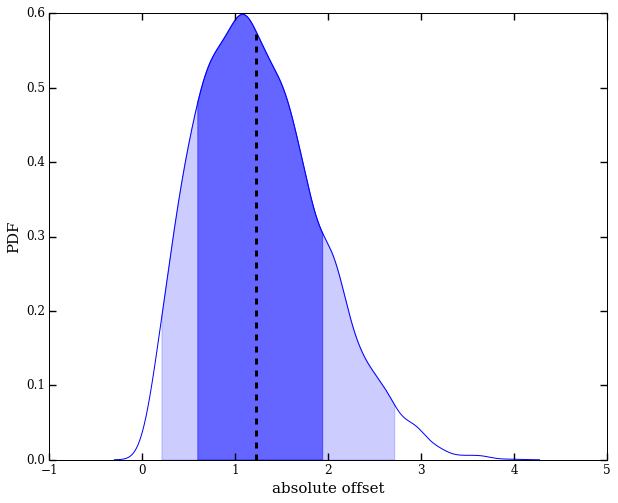

In [68]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
stats = plotCI.CI_loc_plot(abs_rand_vars, ax, lvls=[68., 95., 99.])
ax.set_ylabel('PDF')
ax.set_xlabel('absolute offset')
print (stats)

# use sums of squares instead

It is worthy to note that n-th sums of squares gives $\chi^2$ distribution with $n$ degrees of freedom:


i.e. $s^2 =  x^2 + y^2$

$s^2 \sim \chi^2(n=2)$



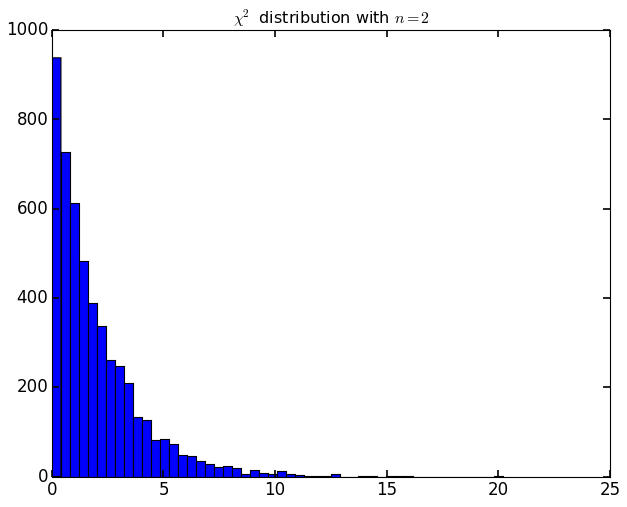

In [63]:
sq_vars = [np.dot(var, var) for var in rand_vars]
_ = plt.hist(sq_vars, bins=50)
plt.title(r'$\chi^2$ distribution with $n=2$')

even though the distribution seems correct with the highest count being in the bin closest to zero, the summary statistics are still not reflection of my actual 2D distribution:

In [84]:
np.mean(sq_vars)

2.0147256385786796

In [87]:
biweight_location(sq_vars)

1.4921211997762305

In [88]:
biweight_midvariance(sq_vars)

1.5526113480356376

# conducting hypothesis test 